In [27]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
from sys import modules
import seaborn as sns
from eval_utils import my_stupid_evaluation_function,mean_absolute_error

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
#Import Data 
X_data= pd.read_csv("/Users/eranbarlevy/Downloads/Regression_project_raz/data/X.csv")
y_data = pd.read_csv("/Users/eranbarlevy/Downloads/Regression_project_raz/data/y.csv")

#Set index
X_data = X_data.set_index('id')
y_data = y_data.set_index('id')

#join
df = X_data.join(y_data, on = 'id') 

In [4]:
#Copy
#Run this for raw data
df = df.copy()

#Check data shap
print(df.shape)

#Columns and type
print(df.info())

(5363, 13)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5363 entries, 2477 to 3572
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0.1         5363 non-null   int64  
 1   Unnamed: 0           5363 non-null   int64  
 2   Age                  5359 non-null   float64
 3   Gender               5359 non-null   object 
 4   Education Level      5360 non-null   object 
 5   Job Title            5361 non-null   object 
 6   Years of Experience  5360 non-null   float64
 7   Country              5363 non-null   object 
 8   Race                 5363 non-null   object 
 9   height               5363 non-null   float64
 10  weight               5361 non-null   float64
 11  professionalism      5360 non-null   float64
 12  Salary               5358 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 586.6+ KB
None


In [5]:
#Drop
#Shape after Drop Null
df = df.dropna()
print(df.shape)

#Drop Retendent Columns
df = df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
print(df.shape)

(5355, 13)
(5355, 11)


In [6]:
df_train, df_test = train_test_split(df, random_state=1, test_size=0.2)
print(df_train.shape)
print(df_test.shape)

(4284, 11)
(1071, 11)


In [7]:
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,professionalism,Salary
id,,,,,,,,,,,
2477,52.0,M,bachelor's|degr,back|end|develope,24.0,australi,Asian,1.800316,95.021957,1150.0,175966.0
76,52.0,F,bachelor,operations|manage,23.0,us,White,2.451414,87.456039,1100.0,160000.0
64,27.0,M,bachelor,junior|accountan,2.0,australi,Australian,1.917509,56.997108,26.0,35000.0
924,32.0,M,bachelor,data|analys,11.0,u,Welsh,2.160562,61.403169,279.0,195000.0
242,39.0,F,bachelor,senior|product|manage,11.0,chin,Korean,1.794105,72.049210,380.0,120000.0


In [8]:
X_train, y_train = df_train.drop("Salary", axis=1), df_train["Salary"]
X_test, y_test = df_test.drop("Salary", axis=1), df_test["Salary"]

In [24]:
def my_stupid_evaluation_function(y_test,y_pred, tolerance = 0.1):
    out = np.abs(y_test-y_pred)/ y_test
    return (out<tolerance).mean()

In [38]:
class MyModel:
    def __init__ (self, col):
        self.col = col

    def fit(self, X, y):
        
        #x and y are the ones from the training set
        self.col_salary_mapper_ = y.groupby(X[self.col]).mean().rename("y_hat") 
        self.fallback_salary_ = y.mean()

    def predict(self, X):
        """"We"""
        out = X.join(self.col_salary_mapper_, on = self.col)
        out = out["y_hat"]
        out = out.fillna(self.fallback_salary_) #what we didnt predict well will be in fallback price
        return out
    
score_board = {}
score_board_mse = {}
for col in X_train.columns:
    reg = MyModel(col = col)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    my_score = my_stupid_evaluation_function(y_test, y_pred, tolerance = 0.1)
    score_board[col] = my_score
  
    my_mse = mean_absolute_error(y_test, y_pred)
    score_board_mse[col] = my_mse

In [40]:
#Base evaluation funtion
pd.Series(score_board)

Age                    0.302521
Gender                 0.163399
Education Level        0.197012
Job Title              0.333333
Years of Experience    0.350140
Country                0.134454
Race                   0.136321
height                 0.117647
weight                 0.117647
professionalism        0.471522
dtype: float64

In [41]:
#we found that professionalism yield the best score
reg = MyModel(col = "professionalism")
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [42]:
y_test.to_frame().join(y_pred)

,Salary,y_hat
id,,
1639,150000.0,125882.352941
1915,190000.0,165000.000000
1568,140000.0,121815.161290
1475,70000.0,58270.833333
2766,160000.0,144583.333333
...,...,...
6025,30000.0,51587.864078
5024,110000.0,114054.642857
421,190000.0,122916.522727


In [44]:
best_col = pd.Series(score_board).idxmax()

#we found that professionalism yield the best score
reg = MyModel(col = best_col)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

"""2/3 ways for join """
y_test.to_frame().join(y_pred)
evaluation_df = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

evaluation_df

,y_test,y_pred
id,,
1639,150000.0,125882.352941
1915,190000.0,165000.000000
1568,140000.0,121815.161290
1475,70000.0,58270.833333
2766,160000.0,144583.333333
...,...,...
6025,30000.0,51587.864078
5024,110000.0,114054.642857
421,190000.0,122916.522727


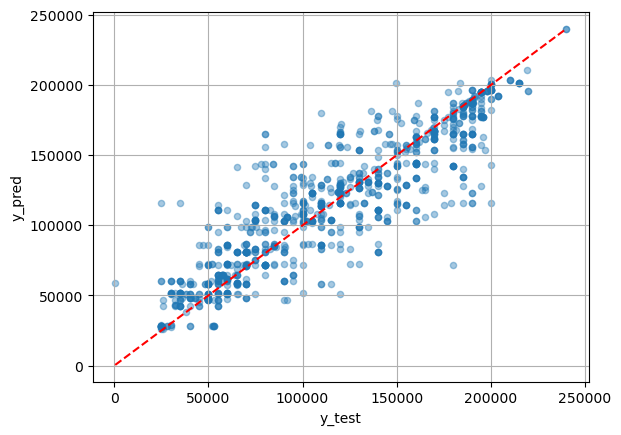

In [45]:
# Create a scatter plot using DataFrame column names
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # 45-degree line

In [46]:
reg.col_salary_mapper_

professionalism
0.0        28446.814286
22.0       25000.000000
23.0       46481.357143
24.0       60350.443038
25.0       51587.864078
              ...      
1710.0    121450.000000
1728.0    192480.142857
1736.0    197354.000000
1881.0    188232.000000
2040.0    188651.000000
Name: y_hat, Length: 265, dtype: float64

In [75]:
reg.fallback_salary_

115793.8779178338

In [47]:
y_pred

id
1639    125882.352941
1915    165000.000000
1568    121815.161290
1475     58270.833333
2766    144583.333333
            ...      
6025     51587.864078
5024    114054.642857
421     122916.522727
4934    111033.844156
5067    142236.267857
Name: y_hat, Length: 1071, dtype: float64

In [48]:
y_test

id
1639    150000.0
1915    190000.0
1568    140000.0
1475     70000.0
2766    160000.0
          ...   
6025     30000.0
5024    110000.0
421     190000.0
4934     80000.0
5067     95000.0
Name: Salary, Length: 1071, dtype: float64

In [49]:
y_pred          #1071
X_test.shape    #1071
(y_test.index == y_pred.index).mean() #mean = 1
y_pred.index.duplicated().mean() #duplicated = 0

0.0

In [50]:
from eval_utils import my_stupid_evaluation_function,mean_absolute_error

#my_score = my_stupid_evaluation_function(y_test.head(),y_pred.head()) #senety check  expect 0
my_score = my_stupid_evaluation_function(y_test, y_pred)
print(my_score)

mean_absolute_error(y_test, y_pred)

0.4715219421101774


16139.642610615068

In [51]:
y_pred.isna().sum()

0

In [52]:
#בודק אם יש את כל הערכים בין טסט לטריין כאשר העמודה היא רציפה
#set(X_train["professionalism"]) - set(X_test["professionalism"])
set(X_test["professionalism"]) - set(X_train["professionalism"])

{11.5, 33.0, 352.0, 832.0, 882.0, 935.0, 1040.0, 1173.0, 1175.0}

In [55]:
X_test[X_test["professionalism"]==33.0]
#X_train[X_train["professionalism"]==33.0]

,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,professionalism
id,,,,,,,,,,
4393,35.0,M,high|scho,junior|sales|associat,2.0,us,Hispanic,2.264594,60.369088,33.0


In [56]:
#הייתי מצפה ל nan אבל אני כן מקבל ערך
some_sample = X_test[X_test["professionalism"]==33]
reg.predict(some_sample)
#115793 is the fallback

id
4393    115793.877918
Name: y_hat, dtype: float64

In [74]:
"""Chech a specipic id from y_pred. we know it exist in the test"""
X_test.loc[4393]

Age                                     35.0
Gender                                     M
Education Level                    high|scho
Job Title              junior|sales|associat
Years of Experience                      2.0
Country                                   us
Race                                Hispanic
height                              2.264594
weight                             60.369088
professionalism                         33.0
Name: 4393, dtype: object

In [84]:
class MySuperModel:
    def __init__(self, cols):
        """cols is a list of columns"""
        self.cols = cols

    def fit(self, X, y):

        #X and y are the ones from the training set
        self.col_price_mapper_ = y.groupby([X[col] for col in self.cols]).mean().rename("y_hat")
        self.fallback_price_s_ = y.mean()

    def predict(self, X):
        
        """We can assume that X contains a column named self.col"""
        out = X.join(self.col_price_mapper_, on = self.cols)
        out = out["y_hat"]
        out = out.fillna(self.fallback_price_s_) #What we didn't predict well will be in fallback price
        return out

In [119]:
reg = MySuperModel(cols = ['professionalism',"Years of Experience","Country"])
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred_train = reg.predict(X_train)


In [120]:
"""All the combination"""
reg.col_price_mapper_ 

professionalism  Years of Experience  Country 
0.0              1.0                  australi     25428.571429
                                      canad        25500.000000
                                      chin         25000.000000
                                      u            26666.666667
                                      us           31444.400000
                                                      ...      
1728.0           34.0                 chin        195270.000000
                                      us          191267.000000
1736.0           33.0                 u           197354.000000
1881.0           35.0                 canad       188232.000000
2040.0           36.0                 canad       188651.000000
Name: y_hat, Length: 1468, dtype: float64

In [121]:
reg.fallback_price_s_

115793.8779178338

In [128]:
print("performance on test",  my_stupid_evaluation_function(y_test,  y_pred, tolerance = 0.1))
print("performance on test",  my_stupid_evaluation_function(y_train,  y_pred_train, tolerance = 0.1))#this is overfitting

performance on test 0.3734827264239029
performance on test 0.5882352941176471


In [123]:
y_pred

id
1639    135000.000000
1915    146000.000000
1568    127750.000000
1475     54000.000000
2766    145000.000000
            ...      
6025     48061.111111
5024    106461.250000
421     102995.000000
4934    142000.000000
5067    116250.000000
Name: y_hat, Length: 1071, dtype: float64

In [124]:
X_test.loc[1639]

Age                                       39.0
Gender                                       M
Education Level                  master's|degr
Job Title              senior|software|enginee
Years of Experience                       11.0
Country                                      u
Race                                     Asian
height                                2.364105
weight                               72.745198
professionalism                          333.0
Name: 1639, dtype: object

In [126]:
"""מצאנו 1 רשומות והממוצע שלהם חזה את המחיר"""
X_train[(X_train["professionalism"]==333) & (X_train["Years of Experience"]==11) & (X_train["Country"]=="chin")]

,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,professionalism
id,,,,,,,,,,
181,39.0,M,master,senior|business|analys,11.0,chin,Chinese,1.926501,67.460778,333.0


In [127]:
y_train.mean()

115793.8779178338

<Axes: xlabel='y_test', ylabel='y_pred'>

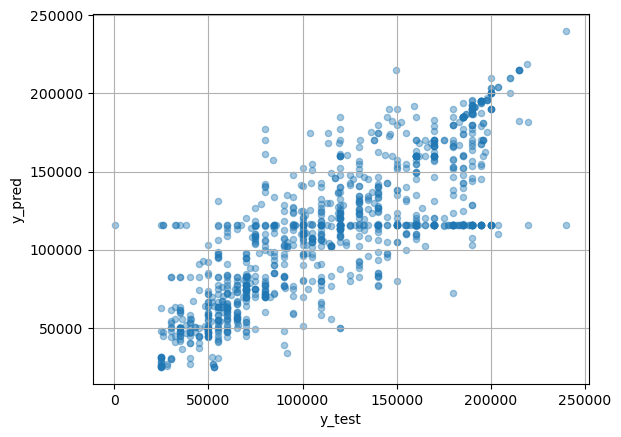

In [129]:
"""The line in the center is the fallback"""
evaluation_df = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)

In [138]:
class MySuperModel:
    def __init__(self, cols):
        """cols is a list of columns"""
        self.cols = cols

    def fit(self, X, y):

        #X and y are the ones from the training set
        self.col_price_mapper_ = y.groupby([X[col] for col in self.cols]).mean().rename("y_hat")
        self.fallback_price_s_ = y.mean()

    def predict(self, X):
        
        """We can assume that X contains a column named self.col"""
        out = X.join(self.col_price_mapper_, on = self.cols)
        out = out["y_hat"]
        out = out.fillna(self.fallback_price_s_) #What we didn't predict well will be in fallback price
        return out

score_board = {}
score_board_mse = {}

for col in X_train.columns:
    reg = MySuperModel(cols=[col])  # Initialize the MySuperModel class with the current column
    reg.fit(X_train, y_train)  # Fit using the entire training dataset
    y_pred = reg.predict(X_test)  # Predict using the entire test dataset


    my_score = my_stupid_evaluation_function(y_test, y_pred, tolerance = 0.1)
    score_board[col] = my_score
  
    my_mse = mean_absolute_error(y_test, y_pred)
    score_board_mse[col] = my_mse

In [142]:
#Base evaluation funtion
pd.Series(score_board)

Age                    0.302521
Gender                 0.163399
Education Level        0.197012
Job Title              0.333333
Years of Experience    0.350140
Country                0.134454
Race                   0.136321
height                 0.117647
weight                 0.117647
professionalism        0.471522
dtype: float64

In [156]:
from itertools import combinations

score_board = {}
score_board_mse = {}

# Iterate through all possible combinations of columns
for num_cols in range(1, len(X_train.columns) + 1):
    for col_combo in combinations(X_train.columns, num_cols):
        reg = MySuperModel(cols=list(col_combo))
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        
        my_score = my_stupid_evaluation_function(y_test, y_pred, tolerance = 0.1)
        score_board[col_combo] = my_score
        print(f"Columns: {col_combo}, My Score: {my_score:.4f}")

        #my_mse = mean_absolute_error(y_test, y_pred)
        #score_board_mse[col] = my_mse


Columns: ('Age',), My Score: 0.3025
Columns: ('Gender',), My Score: 0.1634
Columns: ('Education Level',), My Score: 0.1970
Columns: ('Job Title',), My Score: 0.3333
Columns: ('Years of Experience',), My Score: 0.3501
Columns: ('Country',), My Score: 0.1345
Columns: ('Race',), My Score: 0.1363
Columns: ('height',), My Score: 0.1176
Columns: ('weight',), My Score: 0.1176
Columns: ('professionalism',), My Score: 0.4715
Columns: ('Age', 'Gender'), My Score: 0.2997
Columns: ('Age', 'Education Level'), My Score: 0.4034
Columns: ('Age', 'Job Title'), My Score: 0.6788
Columns: ('Age', 'Years of Experience'), My Score: 0.3875
Columns: ('Age', 'Country'), My Score: 0.2894
Columns: ('Age', 'Race'), My Score: 0.2754
Columns: ('Age', 'height'), My Score: 0.1176
Columns: ('Age', 'weight'), My Score: 0.1176
Columns: ('Age', 'professionalism'), My Score: 0.4463
Columns: ('Gender', 'Education Level'), My Score: 0.2110
Columns: ('Gender', 'Job Title'), My Score: 0.3856
Columns: ('Gender', 'Years of Expe

In [159]:
#Base evaluation funtion
best_combination = max(score_board, key=score_board.get)
best_score = score_board[best_combination]

print(f"Best Combination: {best_combination}, Best Score: {best_score:.4f}")


Best Combination: ('Education Level', 'Job Title', 'professionalism'), Best Score: 0.8562


In [161]:
reg = MySuperModel(cols = ['Education Level', 'Job Title', 'professionalism'])
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred_train = reg.predict(X_train)

rmse = mean_squared_error(y_test, y_pred, squared=False) #18887
rmse

18887.78063973396

<Axes: xlabel='y_test', ylabel='y_pred'>

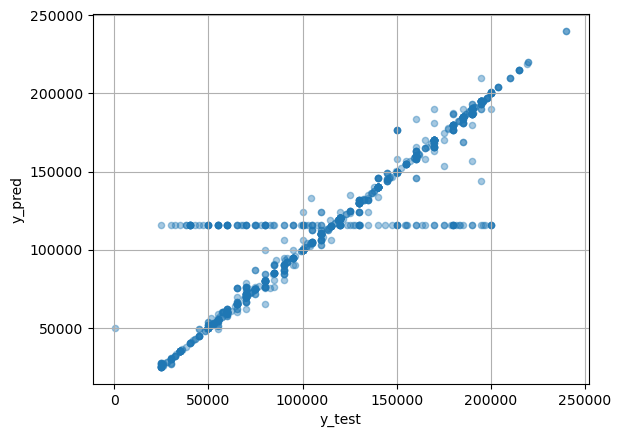

In [162]:
"""The line in the center is the fallback"""
evaluation_df = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
evaluation_df.plot.scatter('y_test', 'y_pred', alpha=0.4, grid=True)